<a href="https://colab.research.google.com/github/Egozit/ds_master_dataton/blob/main/02_team_hak_19_10_visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import pandas as pd
import numpy as np
import requests 
import folium
from folium.plugins import FastMarkerCluster
from folium.plugins import BeautifyIcon as BI
from geopy.geocoders import Nominatim 
import json
import branca
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

# Functions

In [ ]:
def transliterate(name):
    """
    Author: LarsKort
    https://gist.github.com/ledovsky/6398962
    Date: 16/07/2011; 1:05 GMT-4;
    This function replaces Cyrillic characters with the corresponding 
    Latin characters.
    """
    # Dictionary with replacements
    replacement = {'а': 'a', 'б': 'b', 'в': 'v', 'г': 'g', 'д': 'd', 'е': 'e',
              'ё': 'e', 'ж': 'zh', 'з': 'z', 'и': 'i', 'й': 'y', 'к': 'k',
              'л': 'l', 'м': 'm', 'н': 'n', 'о': 'o', 'п': 'p', 'р': 'r',
              'с': 's', 'т': 't', 'у': 'u', 'ф': 'f', 'х': 'h', 'ц': 'c',
              'ч': 'cz', 'ш': 'sh', 'щ': 'scz', 'ъ': '', 'ы': 'y', 'ь': '',
              'э': 'e', 'ю': 'u', 'я': 'ja', 'А': 'A', 'Б': 'B', 'В': 'V',
              'Г': 'G', 'Д': 'D', 'Е': 'E', 'Ё': 'E', 'Ж': 'ZH', 'З': 'Z',
              'И': 'I', 'Й': 'I', 'К': 'K', 'Л': 'L', 'М': 'M', 'Н': 'N',
              'О': 'O', 'П': 'P', 'Р': 'R', 'С': 'S', 'Т': 'T', 'У': 'U',
              'Ф': 'F', 'Х': 'H', 'Ц': 'C', 'Ч': 'CZ', 'Ш': 'SH', 'Щ': 'SCH',
              'Ъ': '', 'Ы': 'y', 'Ь': '', 'Э': 'E', 'Ю': 'U', 'Я': 'YA',
              'ґ': '', 'ї': '', 'є': '', 'Ґ': 'g', 'Ї': 'i', 'Є': 'e', 
              '«':'"','»':'"'}

    # Replacing every character from the dictionary
    for key in replacement:
        name = name.replace(key, replacement[key])
    return name


def plot_map_tpu(tpu_name):
    """
    This function visualizes shopping facilities, which are in the reach 
    distance of transport hub specified in tpu_name 
    """
    geolocator = Nominatim(user_agent="demo")

    tpu_lat = float(
        tpu_data[tpu_data['TPUName'] == tpu_name].tpu_latitude.values[0]['center'])
    tpu_lng = float(
        tpu_data[tpu_data['TPUName'] == tpu_name].tpu_longitude.values[0]['center'])
    tpu_stat = tpu_data[tpu_data['TPUName'] == tpu_name].Status.values[0]
    tpu_year = tpu_data[tpu_data['TPUName'] == tpu_name].YearOfComissioning.values[0]
    tpu_transfer = tpu_data[tpu_data['TPUName'] == tpu_name].AvailableTransfer.values[0]
    tpu_slots = float(tpu_data[tpu_data['TPUName'] == tpu_name].CarCapacity)

    latitude = tpu_lat
    longitude = tpu_lng
    
    obj_icons = ['shopping-basket', 
                   'shopping-cart', 
                   'shopping-bag',
                   'building',
                   'institution']
    #icon_colors = ['#009900', '#0099ff', '#660066', '#cc9900', '#669999']
    icon_colors = ['#3366CC', '#3366CC', '#3366CC', '#3366CC', '#3366CC'] 

    maps = folium.Map(location=[latitude, longitude],
                      tiles='cartodbpositron',
                      zoom_start=14.5)
    # Add map types
    folium.TileLayer('Stamen Toner').add_to(maps)
    folium.TileLayer('OpenStreetMap').add_to(maps)

    # Add transport hub 
    description  = f'<p><b>TPU name: {tpu_name}<br>'
    description += f' ({tpu_stat})</b><br><hr>'
    description += f'<p>Year of comissioning: {tpu_year}'
    description += f'<p>Availible transfer:<br><ul>'
    for option in tpu_transfer.split(';'):
          description += f'<li>{option.lower()}'     
    description += f'</ul><p>Availible parking slots: {tpu_slots}'
    
    iframe = folium.IFrame(html=description, width=600, height=300)
    popup_description = folium.Popup(iframe, max_width=2650) 
    
    
    folium.Marker(location=[float(tpu_lat), float(tpu_lng)],
                  popup=popup_description, tooltip=transliterate(tpu_name),
                  icon=folium.Icon(color='red', icon='train', prefix = 'fa')
                  ).add_to(maps)   
    
    
   # Add trade places
    input_df = main_df[
        (main_df['tpu_name'] == tpu_name) &
        (main_df['object_real_reach_distance'] >= main_df['distance_to_tpu'])
        ]
    
    for address_name in input_df.object_address.unique():
        info = {}
        obj_counter = 0
        tmp_obj_df = input_df[input_df.object_address==address_name]
        info['lat'], info['lng'] = tmp_obj_df.iloc[0].object_latitude,\
                                 tmp_obj_df.iloc[0].object_longitude
        for curr_obj_size in tmp_obj_df.object_size.unique():
            curr_obj_data = []
            
            for name, descr in zip(tmp_obj_df[tmp_obj_df.object_size==\
                                                    curr_obj_size].object_name,
                               tmp_obj_df[tmp_obj_df.object_size==\
                                                    curr_obj_size].object_type):
                curr_obj_data.append(name + ' - <i>' + descr + '<i>')
            obj_counter += len(curr_obj_data)
            info[curr_obj_size] = curr_obj_data
            

        size_names = {1:'Small', 2:'Medium', 3:'Large'}
        description  = f'<p><b>Objects total: {str(obj_counter)}</b><br>'
        description += f'<p>Closest TPU: {tmp_obj_df.tpu_name.iloc[0]}'
        description += f' in {round(tmp_obj_df.distance_to_tpu.iloc[0],0)} m.<br>'
        description += f'<p>Nearest station: {tmp_obj_df.tpu_near_station.iloc[0]}<br><hr>'
        for curr_obj_size in np.sort(tmp_obj_df.object_size.unique())[::-1]:
            if curr_obj_size in info:
                description += f'<b>{size_names[curr_obj_size]} objects total: '
                description += str(len(info[curr_obj_size])) + '</b><ul>'
                for obj_info in info[curr_obj_size]:
                    description += (f'<li>{obj_info}')
                description += '</ul><hr><br>'
        iframe = folium.IFrame(html=description, width=600, height=300)
        popup_description = folium.Popup(iframe, max_width=2650)
        
               
        
        for i in range(0,3):
            if i+1 in info.keys():
                marker_color = icon_colors[i]
                marker_icon = obj_icons[i]
                                
        if 1 < obj_counter <= 10:
            marker_icon = obj_icons[3]
            marker_color = icon_colors[3]
        if obj_counter > 10:
            marker_icon = obj_icons[4]
            marker_color= icon_colors[4]

        folium.Marker(location=[info['lat'], info['lng']], 
                      popup=popup_description,
                      tooltip=transliterate(f'{address_name} - ' +\
                                            f'{obj_counter} мест(а)')[14:], 
                      icon=BI(icon=marker_icon,
                              icon_shape='circle',
                              border_width=2,
                              border_color=marker_color,
                              text_color='#ffffff',
                              #iconSize = [28, 28],
                              #innerIconAnchor = [0, 5],
                              background_color=marker_color
                              )).add_to(maps)    

        
    folium.LayerControl().add_to(maps)

    return maps

def find_area(feature):
    for s in tpu_obj_count.index:
        if s.endswith(feature):
            return tpu_obj_count[s] 

def style_function(feature):
    feature = feature['properties']['NAME']
    obj_count = tpu_obj_count.get(feature, None)
    if isinstance(obj_count, type(None)):
        obj_count = find_area(feature)
    return {
        'fillOpacity': 0.5,
        'color': '#A9A7A7',
        'weight': 2,
        'fillColor': '#ffffff' if obj_count is None else colorscale(obj_count)
    }
    
def show_objects_on_map(input_df, 
                        marker_size=2,
                        zoom=10,
                        obj_as_marker=False,
                        display_districts=True,
                        display_tpu=True, 
                        translit=False):
    """
    This function builds a map with markers of objects on it.
    If location contains many objects - it groups it with the
    summary of the location. (Total objects  and  number   of
    objects from all avalible class)  Description is added as 
    HTML-tagged text. Can be converted from Cyrillic. See opt 
    Be advised: can be slow on large datasets.
    
    Param 'translit' transliterate Cyrillic symbols.
    
    :param pd.df: input_df           - Full or slice
    :param   int: marker_size        - [Dafault=2]    (Optional)
    :param   int: zoom               - [Dafault=10]   (Optional)
    :param  Bool: obj_as_marker      - [Dafault=False](Optional)
    :param  Bool: display_districts  - [Dafault=True] (Optional)
    :param  Bool: display_tpu        - [Dafault=True] (Optional)
    :param  Bool: translit           - [Dafault=False](Optional)
    :returns Folium.map: moscow_map  
    """
    # Map initialization
    geolocator = Nominatim(user_agent="demo")
    address = 'Moscow, Russia'
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    moscow_map = folium.Map(location=[latitude, longitude],
                             tiles='Stamen Toner', 
                             zoom_start=zoom)
    
    # Add map types
    folium.TileLayer('cartodbpositron').add_to(moscow_map)
    folium.TileLayer('OpenStreetMap').add_to(moscow_map)

    # Display area boundaries
    if display_districts==True:
        layer_name = 'Area boundaries'
        area_bound=folium.FeatureGroup(name=layer_name, show=True)
        folium.GeoJson(municipality,
                       style_function=style_function).add_to(area_bound)
        moscow_map.add_child(area_bound)  
    
    # Generating Marker with HTML description for unique location
    layer_name = 'Trade places'
    shop_obj=folium.FeatureGroup(name=layer_name, show=True)
    for address_name in input_df.object_address.unique():
        info = {}
        obj_counter = 0
        tmp_obj_df = input_df[input_df.object_address==address_name]
        info['lat'], info['lng'] = tmp_obj_df.iloc[0].object_latitude,\
                                 tmp_obj_df.iloc[0].object_longitude     
        # Creating Dictionary with location metadata divided into classes
        for curr_obj_size in tmp_obj_df.object_size.unique():
            curr_obj_data = []
            for name, descr in zip(tmp_obj_df[tmp_obj_df.object_size==\
                                                    curr_obj_size].object_name,
                               tmp_obj_df[tmp_obj_df.object_size==\
                                                    curr_obj_size].object_type):
                curr_obj_data.append(f'{name} - <i>{descr}</i>')
            obj_counter += len(curr_obj_data)
            info[curr_obj_size] = curr_obj_data        
        # Generating HTML-tagged description using dictionary with metadata
        size_names = {1:'Small', 2:'Medium', 3:'Large'}
        description  = f'<p><b>Objects total: {str(obj_counter)}</b><br>'
        description += f'<p>Closest TPU: {tmp_obj_df.tpu_name.iloc[0]}'
        description += f' in {round(tmp_obj_df.distance_to_tpu.iloc[0],0)} m.<br>'
        description += f'<p>Nearest station: {tmp_obj_df.tpu_near_station.iloc[0]}<br><hr>'
        for curr_obj_size in np.sort(tmp_obj_df.object_size.unique())[::-1]:
            if curr_obj_size in info:
                description += f'<b>{size_names[curr_obj_size]} objects total: '
                description += str(len(info[curr_obj_size])) + '</b><ul>'
                for obj_info in info[curr_obj_size]:
                    description += (f'<li>{obj_info}')
                description += '</ul><hr><br>'
        if translit==True:
            description = transliterate(description)
        iframe = folium.IFrame(html=description, width=600, height=300)
        popup_description = folium.Popup(iframe, max_width=2650)      
        # Choosing color accoring to top class of objects in the location
        colors = ['#006699', '#339900', '#cc6600']
        icon_shapes = ['marker', 'circle-dot', 'rectangle', 
                     'rectangle-dot', 'doughnut', 'circle']
        obj_icons = ['shopping-basket', 
                   'shopping-cart', 
                   'shopping-bag',
                   'building',
                   'institution']
        for i in range(0,3):
            if i+1 in info.keys():
                marker_color = colors[i]
                icon_color = colors[i]
                marker_icon = obj_icons[i]
                icon_shape = icon_shapes[i]      
        if 1 < obj_counter <= 10:
            marker_icon = obj_icons[3]
        if obj_counter > 10:
            marker_icon = obj_icons[4]
        # Marker generation
        if obj_as_marker==False:
            folium.CircleMarker(
                  [info['lat'], info['lng']],
                  radius= (marker_size + np.log(obj_counter))*2,
                  popup=popup_description,
                  tooltip=transliterate(f'{address_name} - ' +\
                                    f'{obj_counter} мест(а)')[14:],
                  color=marker_color,
                  fill=True,
                  fill_color=marker_color,
                  parse_html=True).add_to(shop_obj)
        else:
            folium.Marker(location=[info['lat'], 
                                    info['lng']], 
                          popup=popup_description,
                          tooltip=transliterate(f'{address_name} - ' +\
                                            f'{obj_counter} мест(а)')[14:], 
                          icon=BI(icon=marker_icon,
                          icon_shape='marker',
                          border_width=2,
                          border_color='#ffffff',
                          text_color='#ffffff',
                          background_color=marker_color
                          )).add_to(shop_obj)

    moscow_map.add_child(shop_obj)
    
    # Display tpu data on map    
    if display_tpu==True:
        layer_name = 'Transport hubs'
        colorscale = branca.colormap.linear.YlGnBu_09.scale(color_min, color_max)
        tpu_obj=folium.FeatureGroup(name=layer_name, show=True)
        tpu_lat = tpu_data.tpu_latitude.apply(lambda x: x['center'])
        tpu_lon = tpu_data.tpu_longitude.apply(lambda x: x['center'])  
        
        for lat, lng, tpu_name, tpu_stat, year, transfer, slots in zip(
                            tpu_lat,
                            tpu_lon,
                            tpu_data.TPUName,
                            tpu_data.Status,
                            tpu_data.YearOfComissioning,
                            tpu_data.AvailableTransfer,
                            tpu_data.CarCapacity): 
            
            description  = f'<p><b>TPU name: {tpu_name}<br>'
            description += f' ({tpu_stat})</b><br><hr>'
            description += f'<p>Year of comissioning: {year}'
            description += f'<p>Availible transfer:<br><ul>'
            for option in transfer.split(';'):
                description += f'<li>{option.lower()}'
            description += f'</ul><p>Availible parking slots: {slots}'        
            if translit==True:
                description = transliterate(description)        
            iframe = folium.IFrame(html=description, width=600, height=300)
            popup_description = folium.Popup(iframe, max_width=2650)        
            folium.Marker(location=[float(lat), float(lng)], 
                      popup=popup_description,
                      tooltip=transliterate(tpu_name),
                      icon=folium.Icon(color="red", 
                                       icon='train',
                                       prefix='fa')).add_to(tpu_obj)
        moscow_map.add_child(tpu_obj)  
    
    # Add colorbar and LayerControl
    if display_districts==True:
        colorscale.add_to(moscow_map)
    folium.LayerControl().add_to(moscow_map)
    
    return moscow_map


def split_line(string, max_length):
    space_pos = string[max_length:].find(' ')
    if space_pos>0:
        first_line_end = max_length + string[max_length:].find(' ')
        string = string[:first_line_end] +\
                 string[first_line_end:].replace(' ', '\n', 1)
    return string

def plot_top_by_col(col, df, n, name, other=False, translite=False, 
                    max_string_len=15, horizontally=False, labels =[],
                     palette = sns.color_palette("pastel")):
    '''
    This function plot barplot for selected column 
    '''
    angle = 0
    temp_df = df[col].value_counts()
    df_other = temp_df.iloc[n:].sum()
    temp_df = temp_df.iloc[:n]
    if other == True:
        temp_df['other'] =  df_other
        
    if translite == True:
        temp_df.index=[transliterate(name) for name in temp_df.index]
    if  isinstance(temp_df.index[0], str):   
        max_width = max([len(str) for str in temp_df.index])
        if max_width > max_string_len:
            angle = 90
        
        temp_df.index = [split_line(name, max_string_len) for
                         name in temp_df.index]
    if horizontally ==True:  
        ax = sns.barplot(y=temp_df.index, x=temp_df, data=main_df,
                 palette=palette)
        ax.set(xlabel='Count')
        if len(labels)>0:
            ax.set_yticklabels(labels)

    else:
    
        ax = sns.barplot(x=temp_df.index, y=temp_df, data=main_df,
                 palette=palette)
        ax.set(ylabel='Count')
        if len(labels)>0:
            ax.set_xticklabels(labels)
        else:
            ax.set_xticklabels(ax.get_xticklabels(),rotation=angle)
    ax.set_title(name)

    plt.show()

# Data loading

In [ ]:
url = 'https://drive.google.com/uc?export=download&id=179ShmAMQsWjTCGHWthf75jCD1lh7WPLC'
main_df = pd.read_csv(url, sep=';', encoding='cp1251',
                      index_col=0)
main_df.head()

object_global_id  ... object_district_generalplace_rent_price_per_m2
0         637390942  ...                                         2500.0
1         637391109  ...                                         4050.0
2         637391684  ...                                         1580.0
3         637391714  ...                                         2500.0
4         637391844  ...                                         2084.0

[5 rows x 44 columns]

In [ ]:
url = 'https://drive.google.com/uc?export=download&id=1cAbeGoe1LMfMCIUqQbkU5qfvh_fJO8O8'
tpu_data = pd.read_csv(url, sep=';', encoding='cp1251',
                      index_col=0)
tpu_data.tpu_longitude = tpu_data.tpu_longitude.apply(literal_eval)
tpu_data.tpu_latitude = tpu_data.tpu_latitude.apply(literal_eval)

tpu_data.head()

TPUName  ...  passengers_per_day
0   Транспортно-пересадочный узел «Авиамоторная»  ...            399000.0
1  Транспортно-пересадочный узел «Автозаводская»  ...             86600.0
2  Транспортно-пересадочный узел «Академическая»  ...             47700.0
3      Транспортно-пересадочный узел «Алабушево»  ...                 NaN
4   Транспортно-пересадочный узел «Алексеевская»  ...             29200.0

[5 rows x 16 columns]

In [ ]:
tpu_obj_count = main_df['object_district'].value_counts()
municipality = json.loads(requests.get(
    'http://gis-lab.info/data/mos-adm/mo.geojson').text)
color_max = tpu_obj_count.max()
color_min = tpu_obj_count.min()

In [ ]:
tpu_data[tpu_data.TPUName.str.contains('шоссе')]

TPUName  ...  passengers_per_day
7    Транспортно-пересадочный узел «Аминьевское шоссе»  ...                 NaN
22     Транспортно-пересадочный узел «Боровское шоссе»  ...             60000.0
116     Транспортно-пересадочный узел «Открытое шоссе»  ...             30800.0
141    Транспортно-пересадочный узел «Пятницкое шоссе»  ...             24000.0

[4 rows x 16 columns]

# Data visualisation

## Maps

In [ ]:
colorscale = branca.colormap.linear.YlGnBu_09.scale(color_min, color_max)
show_objects_on_map(main_df.head(1000), 
                    marker_size=2.5,
                    obj_as_marker=False, 
                    display_districts=True, 
                    display_tpu=True, 
                    translit=False)

In [ ]:
tpu_data.TPUName.unique()[1:10]

array(['Транспортно-пересадочный узел «Автозаводская»',
       'Транспортно-пересадочный узел «Академическая»',
       'Транспортно-пересадочный узел «Алабушево»',
       'Транспортно-пересадочный узел «Алексеевская»',
       'Транспортно-пересадочный узел «Алма-Атинская»',
       'Транспортно-пересадочный узел «Алтуфьево»',
       'Транспортно-пересадочный узел «Аминьевское шоссе»',
       'Транспортно-пересадочный узел «Арбатская»',
       'Транспортно-пересадочный узел «Аэропорт»'], dtype=object)

In [ ]:
plot_map_tpu('Транспортно-пересадочный узел «Солнечная»')

## Graphics

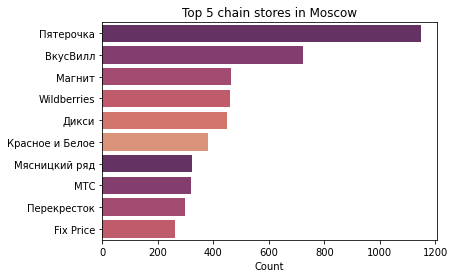

In [ ]:
plot_top_by_col('object_operating_company', main_df, 10,
                'Top 5 chain stores in Moscow',
                other=False, translite=False, horizontally=True,
                palette = sns.color_palette("flare_r"))

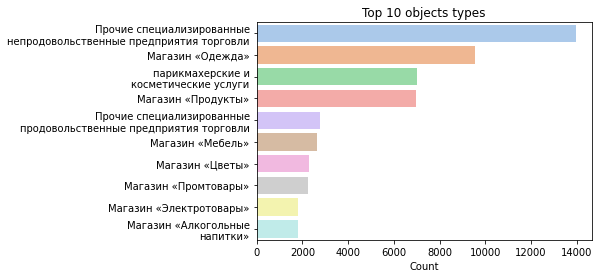

In [ ]:
plot_top_by_col('object_type', main_df, 10, 'Top 10 objects types', 
                other=False, translite=False, horizontally=True)

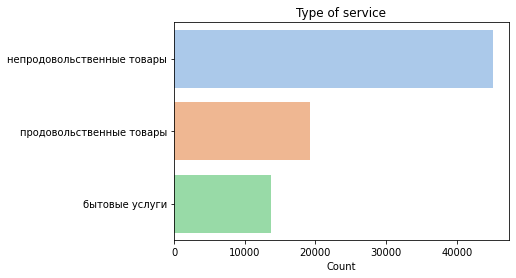

In [ ]:
plot_top_by_col('object_service_type', main_df, 3,
                'Type of service',
                other=False, translite=False, horizontally=True,
                labels = ['непродовольственные товары',
                    'продовольственные товары',
                    'бытовые услуги'] )

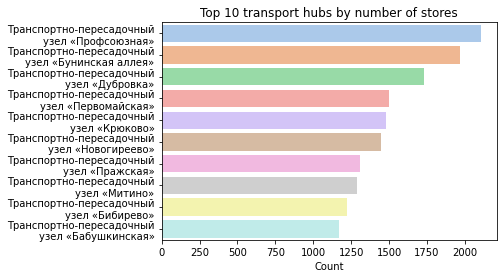

In [ ]:
plot_top_by_col('tpu_name', main_df, 10,
                'Top 10 transport hubs by number of stores',
                other=False, translite=False, horizontally=True)

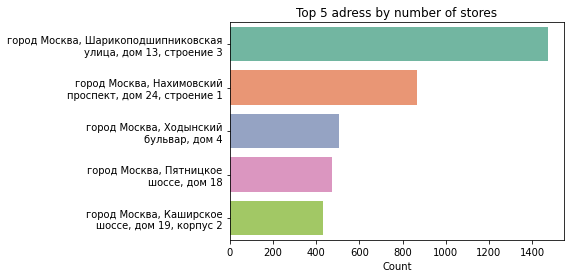

In [ ]:
plot_top_by_col('object_address', main_df, 5,
                'Top 5 adress by number of stores', 
                other=False, translite=False, horizontally=True,
                palette = sns.color_palette("Set2"))

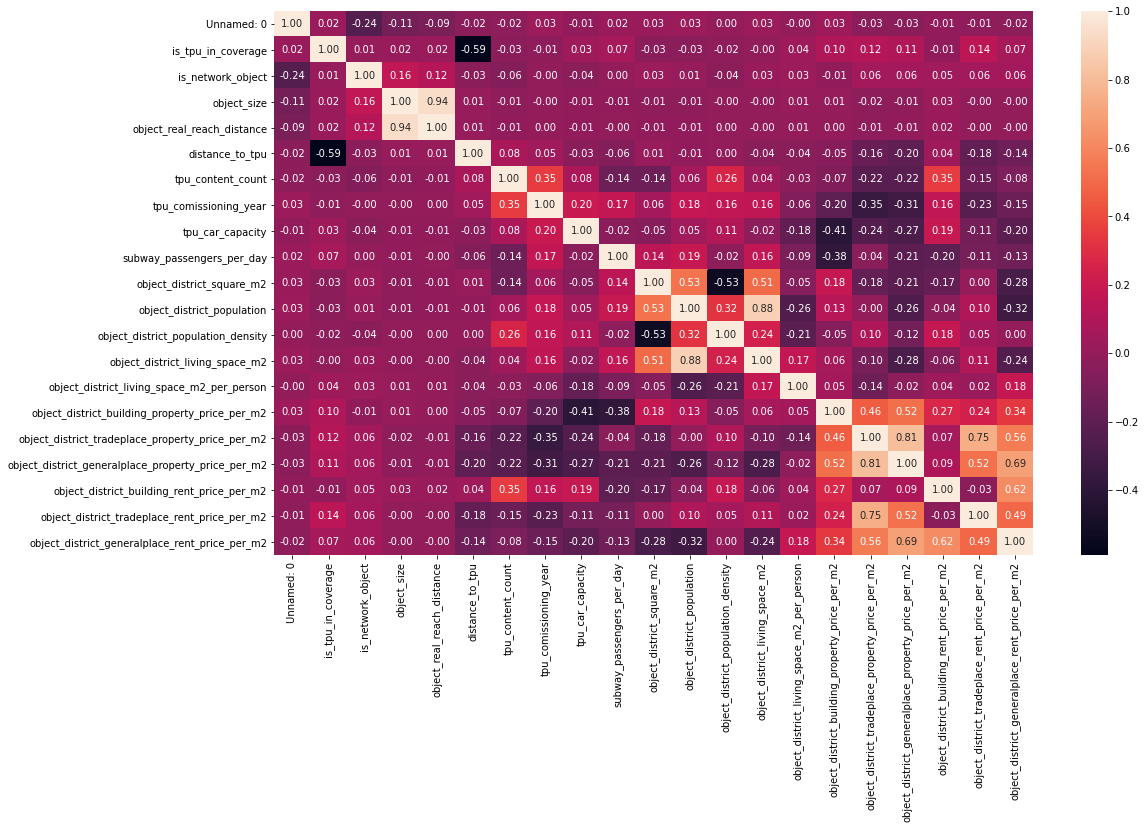

In [ ]:
temp_df = main_df.select_dtypes([np.number]).drop(
    columns=['object_global_id', 'tpu_global_id',
             'object_longitude', 'object_latitude'])

corr_df = temp_df.corr()
fig, ax = plt.subplots(figsize=(17, 10))
sns.heatmap(corr_df, annot=True, fmt=".2f")
plt.show()

### Other graphics

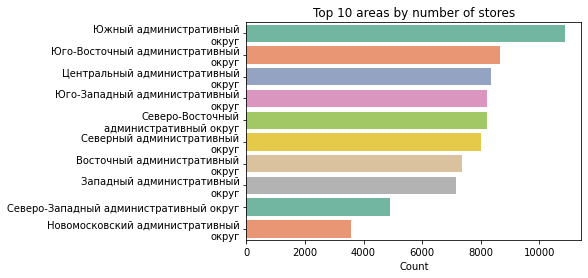

In [ ]:
plot_top_by_col('object_area', main_df, 10, 'Top 10 areas by number of stores',
                other=False, horizontally=True,
                palette = sns.color_palette("Set2"))

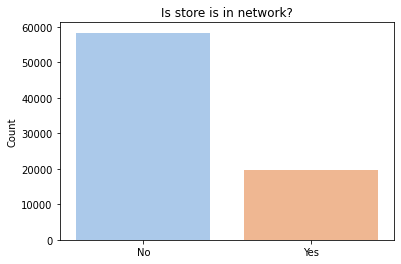

In [ ]:
plot_top_by_col('is_network_object', main_df, 3, 'Is store is in network?',
                labels =  ['No', 'Yes'])

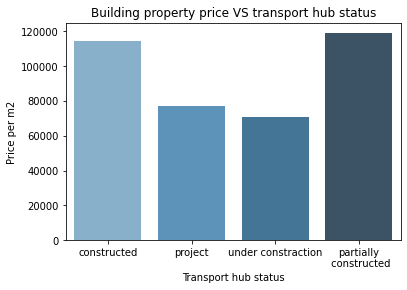

In [ ]:
temp_df = main_df.groupby('tpu_status')['object_district_building_property_price_per_m2'].std()         
ax = sns.barplot(x=['constructed',  'project',
                    'under constraction', 'partially\n constructed'],
                 y=temp_df, palette="Blues_d")
ax.set(ylabel='Price per m2', xlabel='Transport hub status')
ax.set_title('Building property price VS transport hub status')
plt.show()

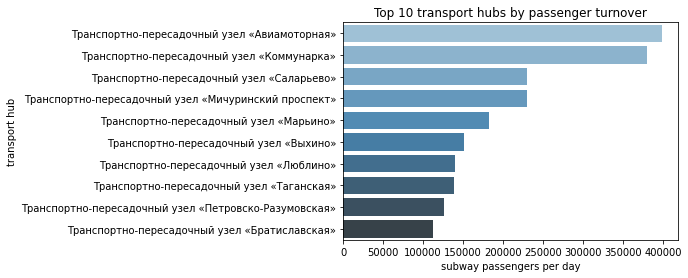

In [ ]:
temp_df = main_df[['tpu_name', 'subway_passengers_per_day']].drop_duplicates()
temp_df = temp_df.sort_values('subway_passengers_per_day', ascending=False)[0:10]
ax = sns.barplot(y ='tpu_name', x='subway_passengers_per_day', 
                 data = temp_df, palette="Blues_d")
ax.set(ylabel='transport hub', xlabel = 'subway passengers per day')
ax.set_title('Top 10 transport hubs by passenger turnover')
plt.show()

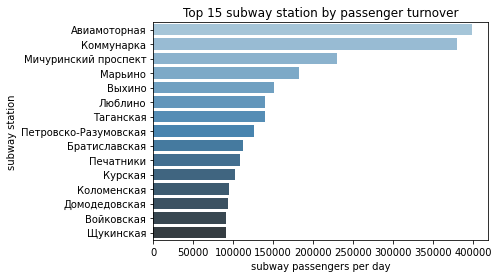

In [ ]:
temp_df = main_df[['subway_station', 'subway_passengers_per_day']].drop_duplicates()
temp_df = temp_df.sort_values('subway_passengers_per_day', ascending=False)[0:15]
ax = sns.barplot(y ='subway_station', x='subway_passengers_per_day', 
                 data = temp_df, palette="Blues_d")
ax.set(ylabel='subway station', xlabel = 'subway passengers per day')
ax.set_title('Top 15 subway station by passenger turnover')
plt.show()